In [114]:
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)  # set default size of plots
#plt.rcParams['image.aspect'] = 1.3
plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style
#plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['savefig.dpi'] = 300  #图片像素
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['lines.markersize'] = 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False #display only a left and bottom box border
plt.rcParams['legend.edgecolor'] = 'white'
plt.rcParams['axes.axisbelow'] = False
plt.rcParams['grid.color'] = 'white'

# load dataset

In [43]:
r = requests.get('https://raw.githubusercontent.com/cystanford/Titanic_Data/master/train.csv')
#'https://github.com/cystanford/Titanic_Data/blob/master/test.csv')
with io.BytesIO(r.content) as f:
    train = pd.read_csv(f)
print(train.head())
r = requests.get('https://raw.githubusercontent.com/cystanford/Titanic_Data/master/test.csv')
#'https://github.com/cystanford/Titanic_Data/blob/master/test.csv')
with io.BytesIO(r.content) as f:
    test = pd.read_csv(f)
print('_'*40)
print(test.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

# Exploratory Data Analysis

## data types

In [10]:
print(train.info())
print('_' * 40)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non

`Which features are categorical?`  
These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.  
**Categorical**: Survived, Sex, and Embarked.  
**Ordinal**: Pclass.

`Which features are numerical?`  
Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.  
**Continous**: Age, Fare.  
**Discrete**: SibSp, Parch.  

`Which features are mixed data types?`  
Numerical, alphanumeric data within same feature. These are candidates for correcting goal.  
**Ticket** is a mix of numeric and alphanumeric data types.  
**Cabin** is alphanumeric.

`Which features may contain errors or typos?`  
This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.  
Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

`Which features contain blank, null or empty values?`  
These will require correcting.  
**Cabin > Age > Embarked** features contain a number of null values in that order for the training dataset.  
**Cabin > Age** are incomplete in case of test dataset.  

## variable identification

In [15]:
print(train.describe())
print('_' * 40)
# print(train.dtypes)
# print('_'*40)
# print(train.apply(lambda x:sum(x.isnull()),axis=0))
print(test.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
________________________________________
       PassengerId      Pclass         A

`What is the distribution of numerical feature values across the samples?`  
This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.  
- Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).  
- Survived is a categorical feature with 0 or 1 values.  
- Around 38% samples survived representative of the actual survival rate at 32%.  
- Most passengers (> 75%) did not travel with parents or children.  
- Nearly 30% of the passengers had siblings and/or spouse aboard.  
- Fares varied significantly with few passengers (<1%) paying as high as $512.  
- Few elderly passengers (<1%) within age range 65-80.

In [16]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Weir, Col. John",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


`What is the distribution of categorical features?`  
Names are unique across the dataset (count=unique=891)  
Sex variable as two possible values with 65% male (top=male, freq=577/count=891).  
Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.  
Embarked takes three possible values. S port used by most passengers (top=S)  
Ticket feature has high ratio (22%) of duplicate values (unique=681).

## relationship between features & survival

### non-continuous feature & survival

In [18]:
train[['Pclass', 'Survived']].groupby(['Pclass'],
                                      as_index=False).mean().sort_values(
                                          by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [22]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(
    by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [23]:
train[["SibSp", "Survived"]].groupby(['SibSp'],
                                     as_index=False).mean().sort_values(
                                         by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [24]:
train[["Parch", "Survived"]].groupby(['Parch'],
                                     as_index=False).mean().sort_values(
                                         by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### continuous features & survival

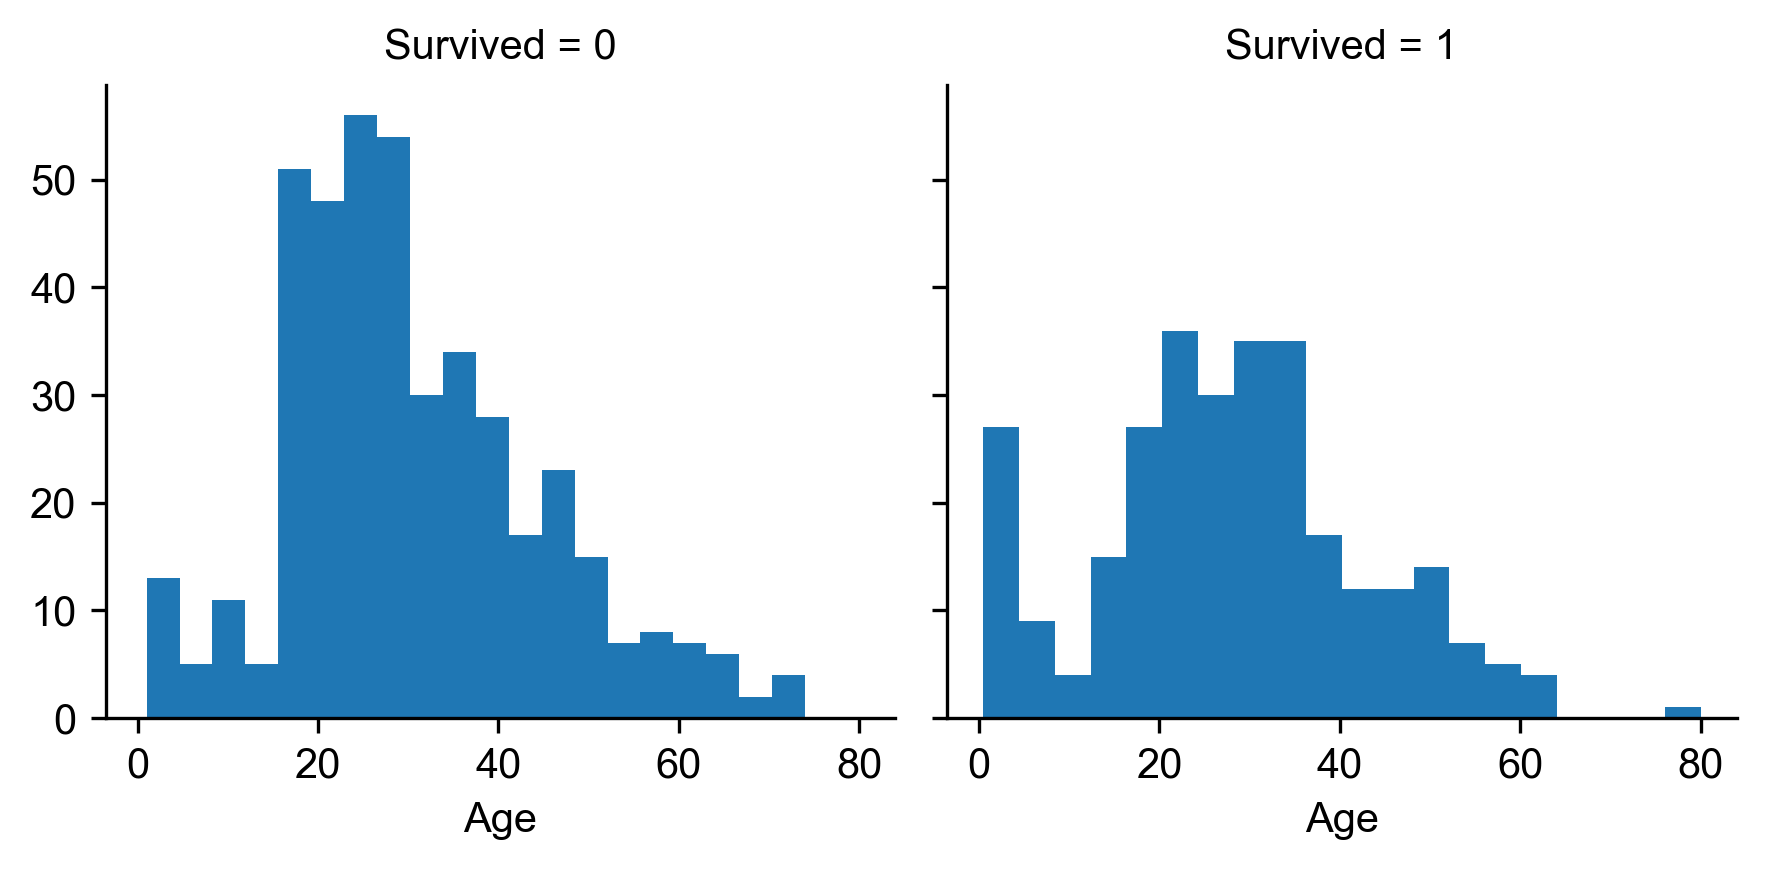

In [83]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

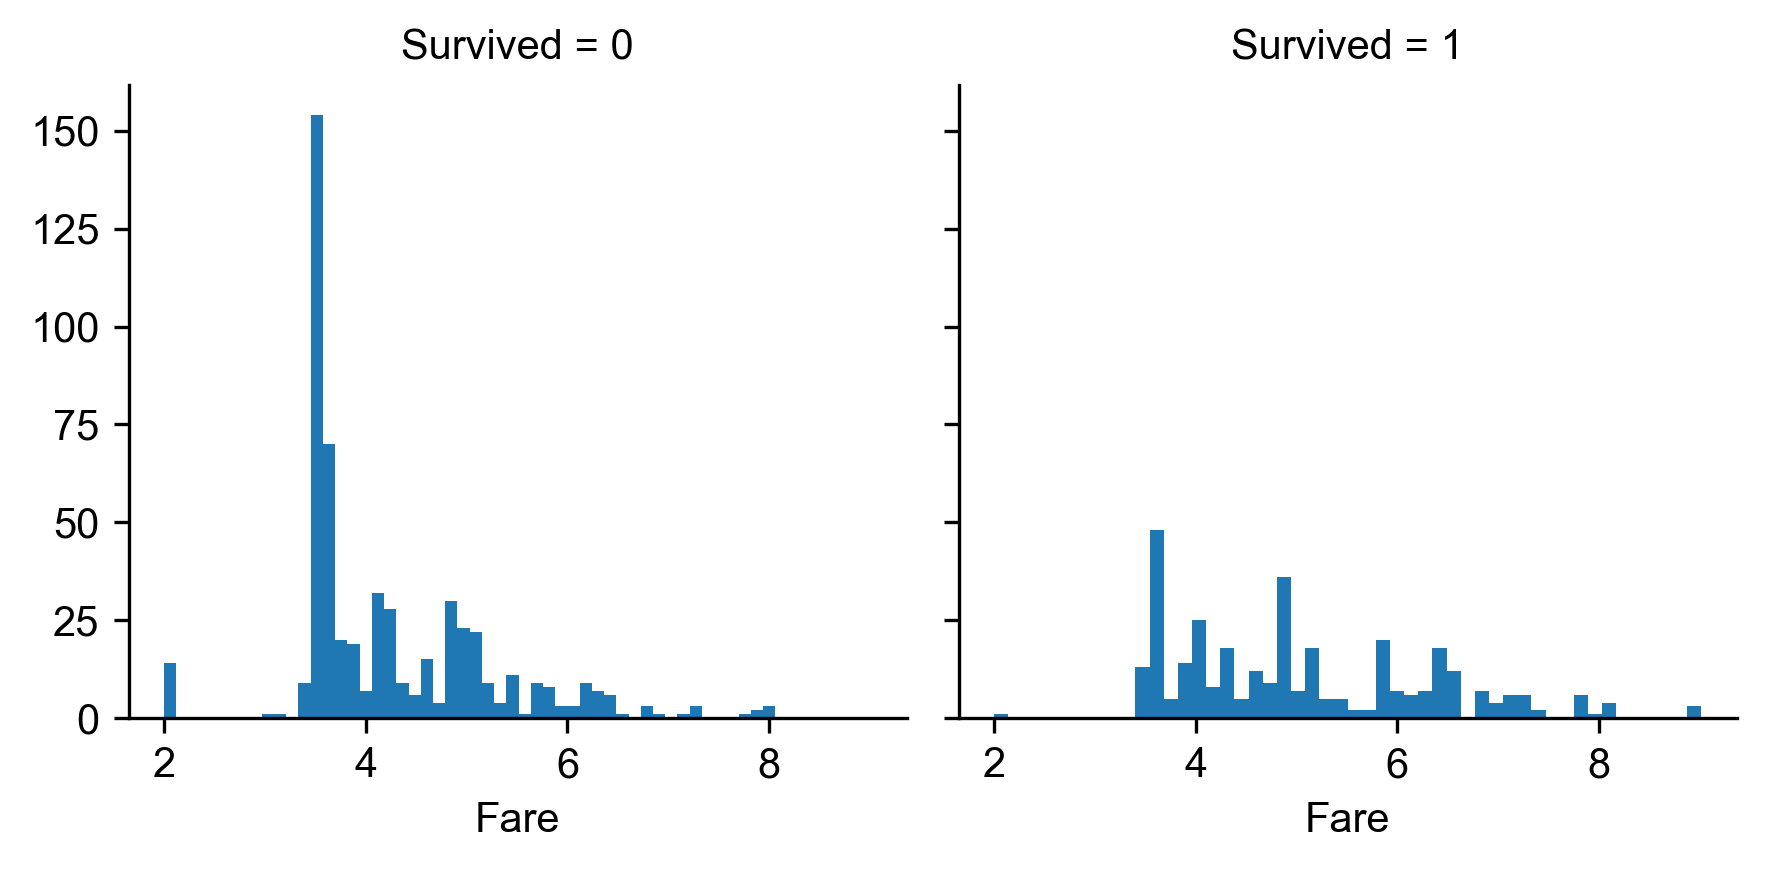

In [90]:
Fare = train[['Survived', 'Fare']]
Fare.Fare = train.Fare.apply(lambda x: np.log2(x + 4))
g = sns.FacetGrid(Fare, col='Survived')
g.map(plt.hist, 'Fare', bins=50)

### numerical & ordinal features

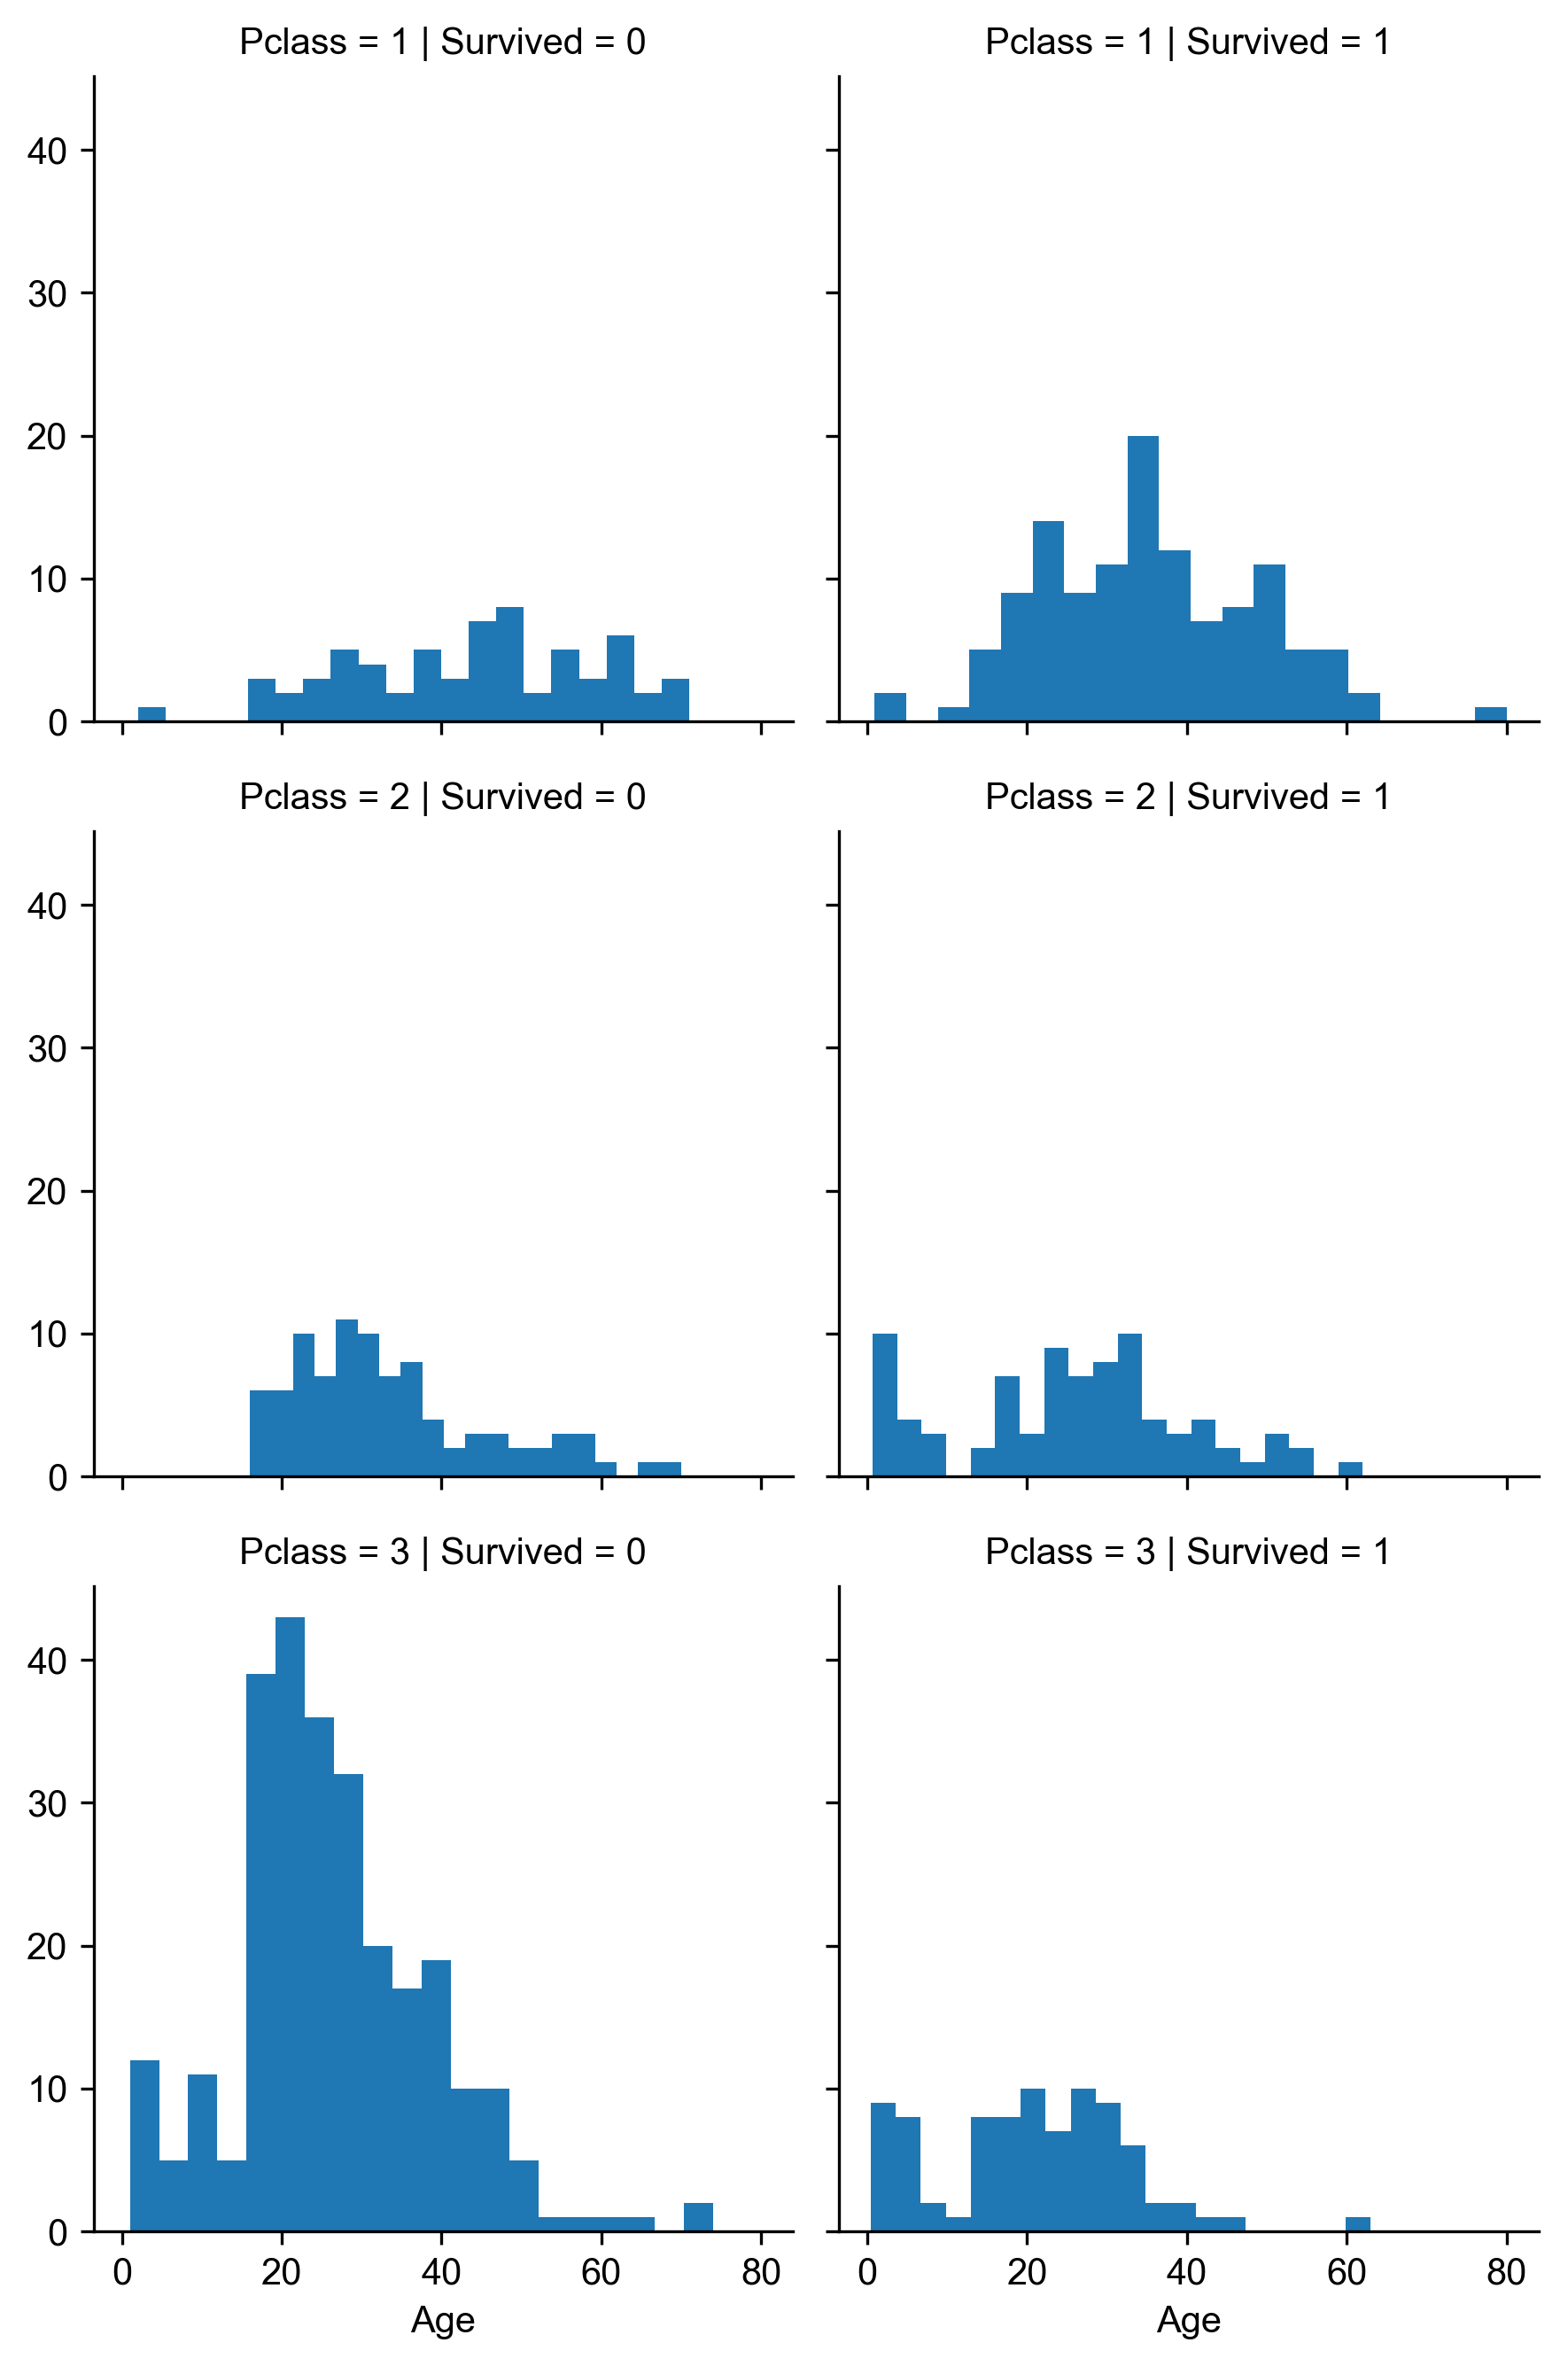

In [95]:
g = sns.FacetGrid(train, col='Survived', row='Pclass')
g.map(plt.hist, 'Age', bins=20)

### categorical features

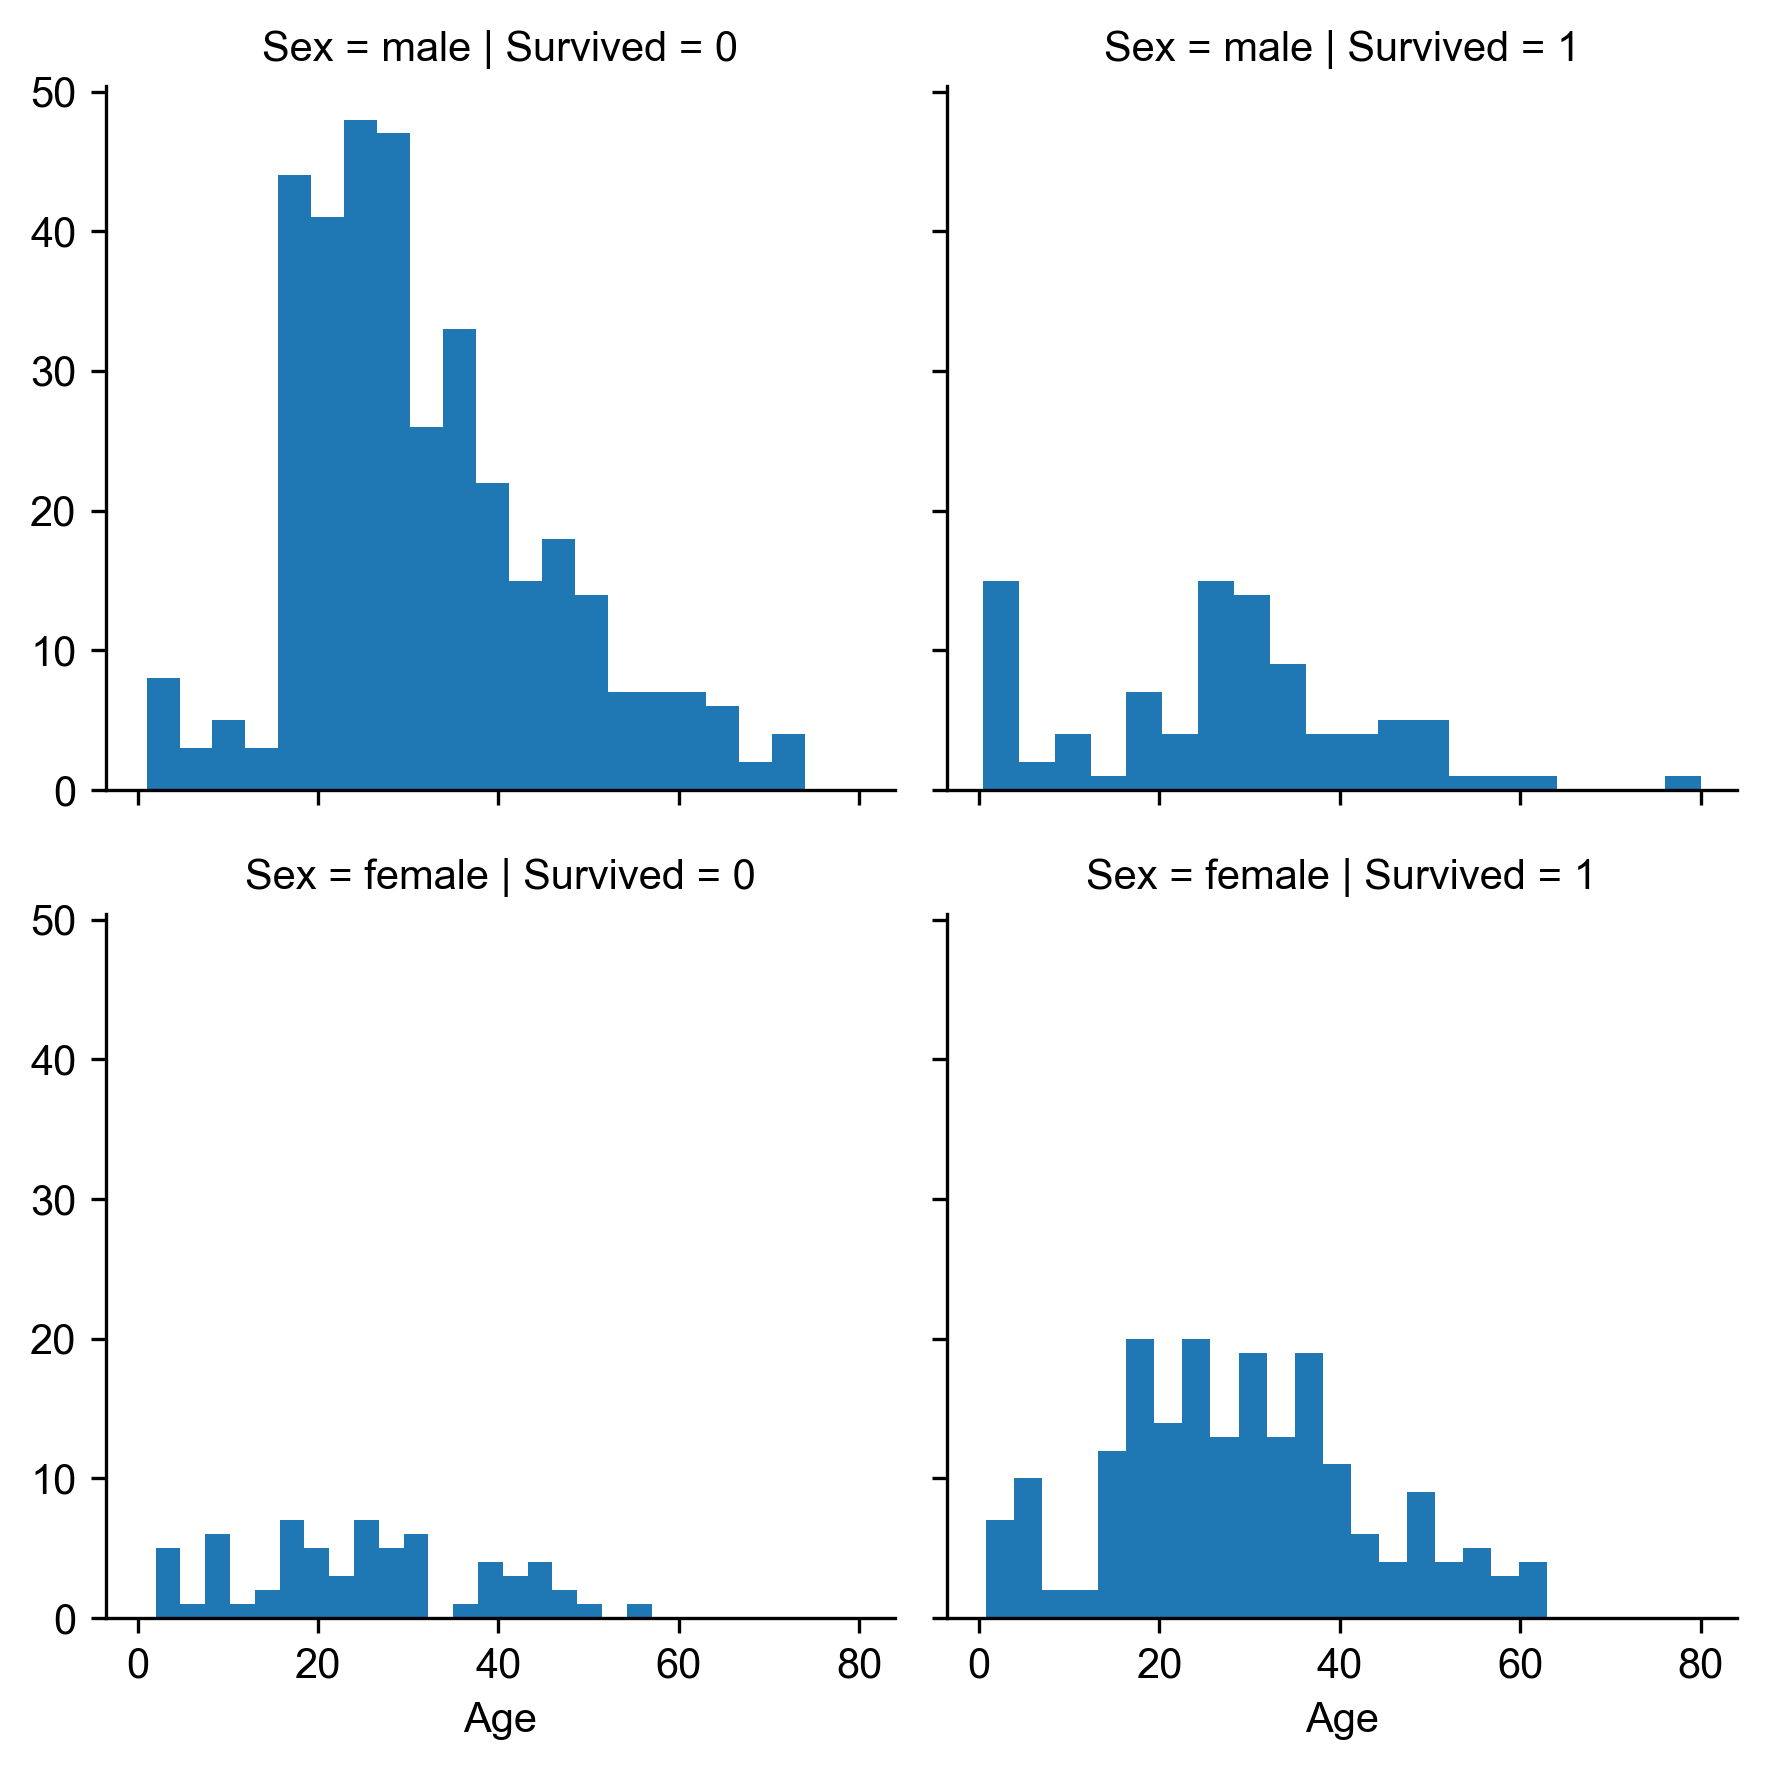

In [96]:
g = sns.FacetGrid(train, col='Survived', row='Sex')
g.map(plt.hist, 'Age', bins=20)

/Users/mymac/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/mymac/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


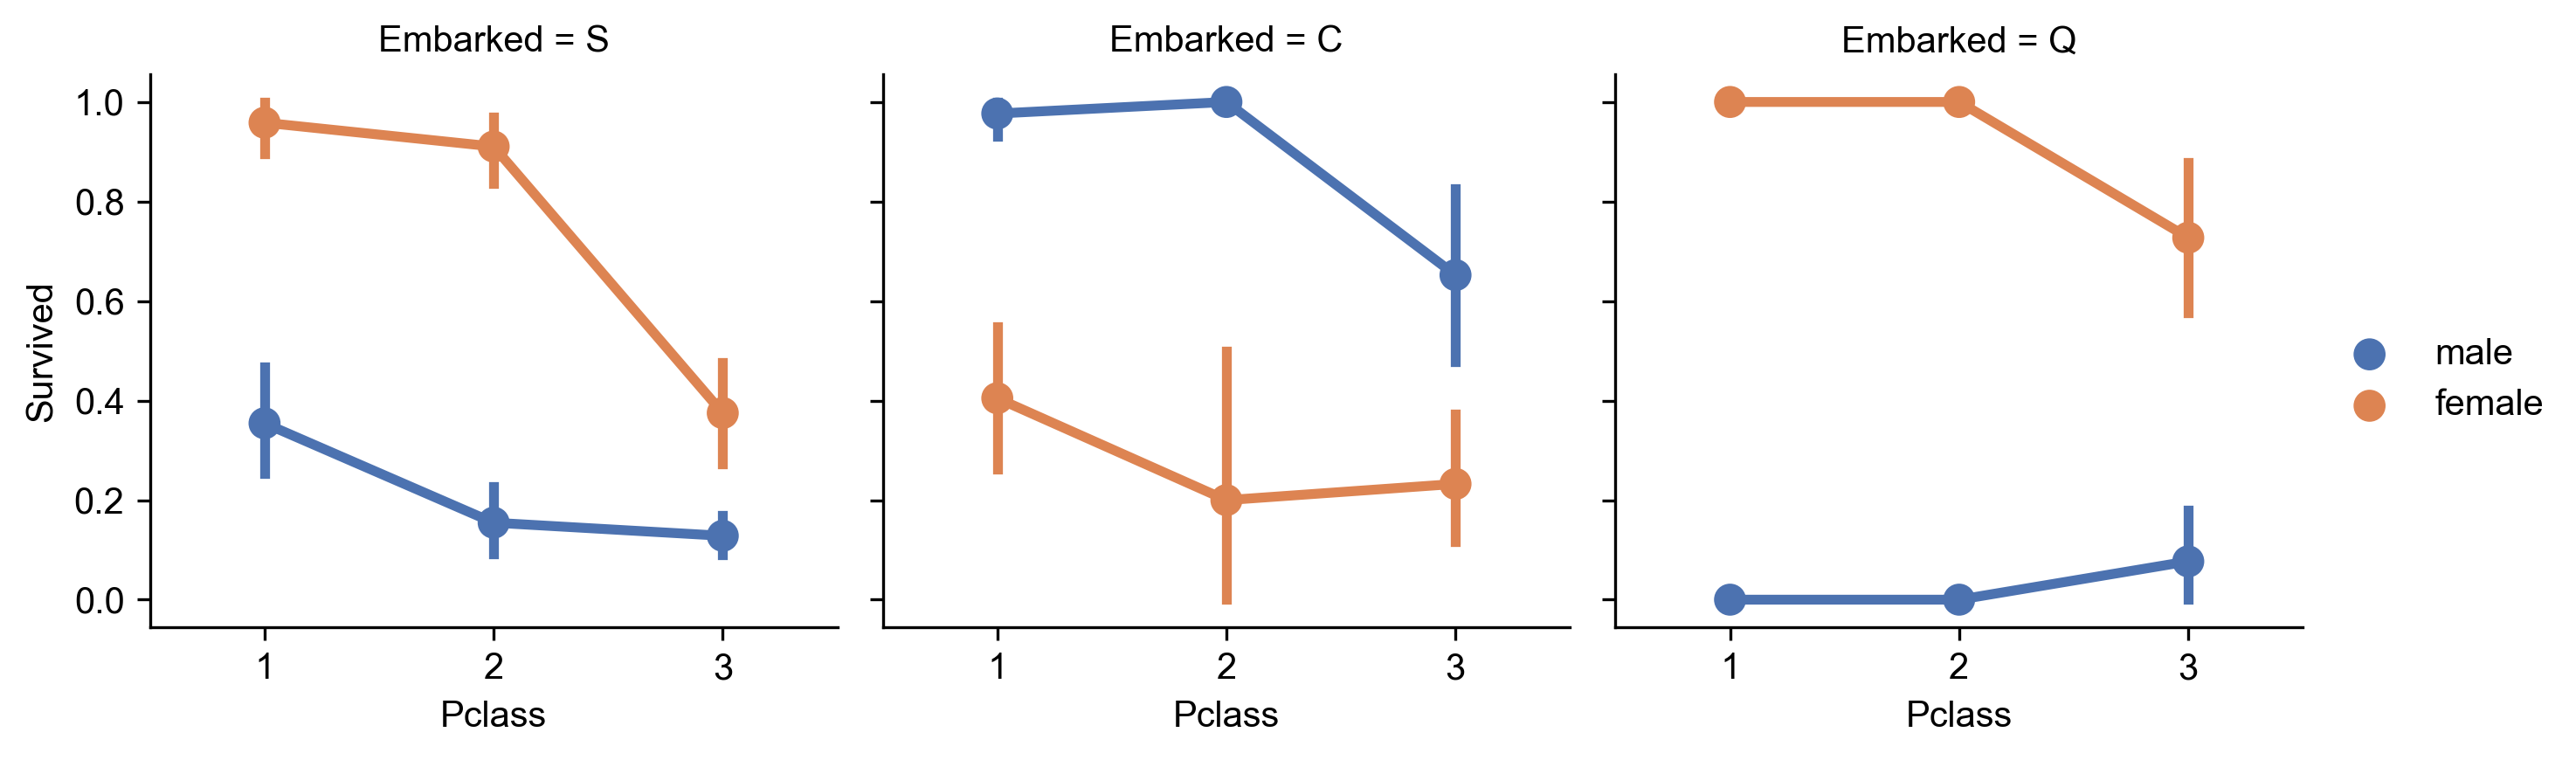

In [101]:
g = sns.FacetGrid(train, col='Embarked')
g.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
g.add_legend()

### categorical and numerical features

/Users/mymac/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


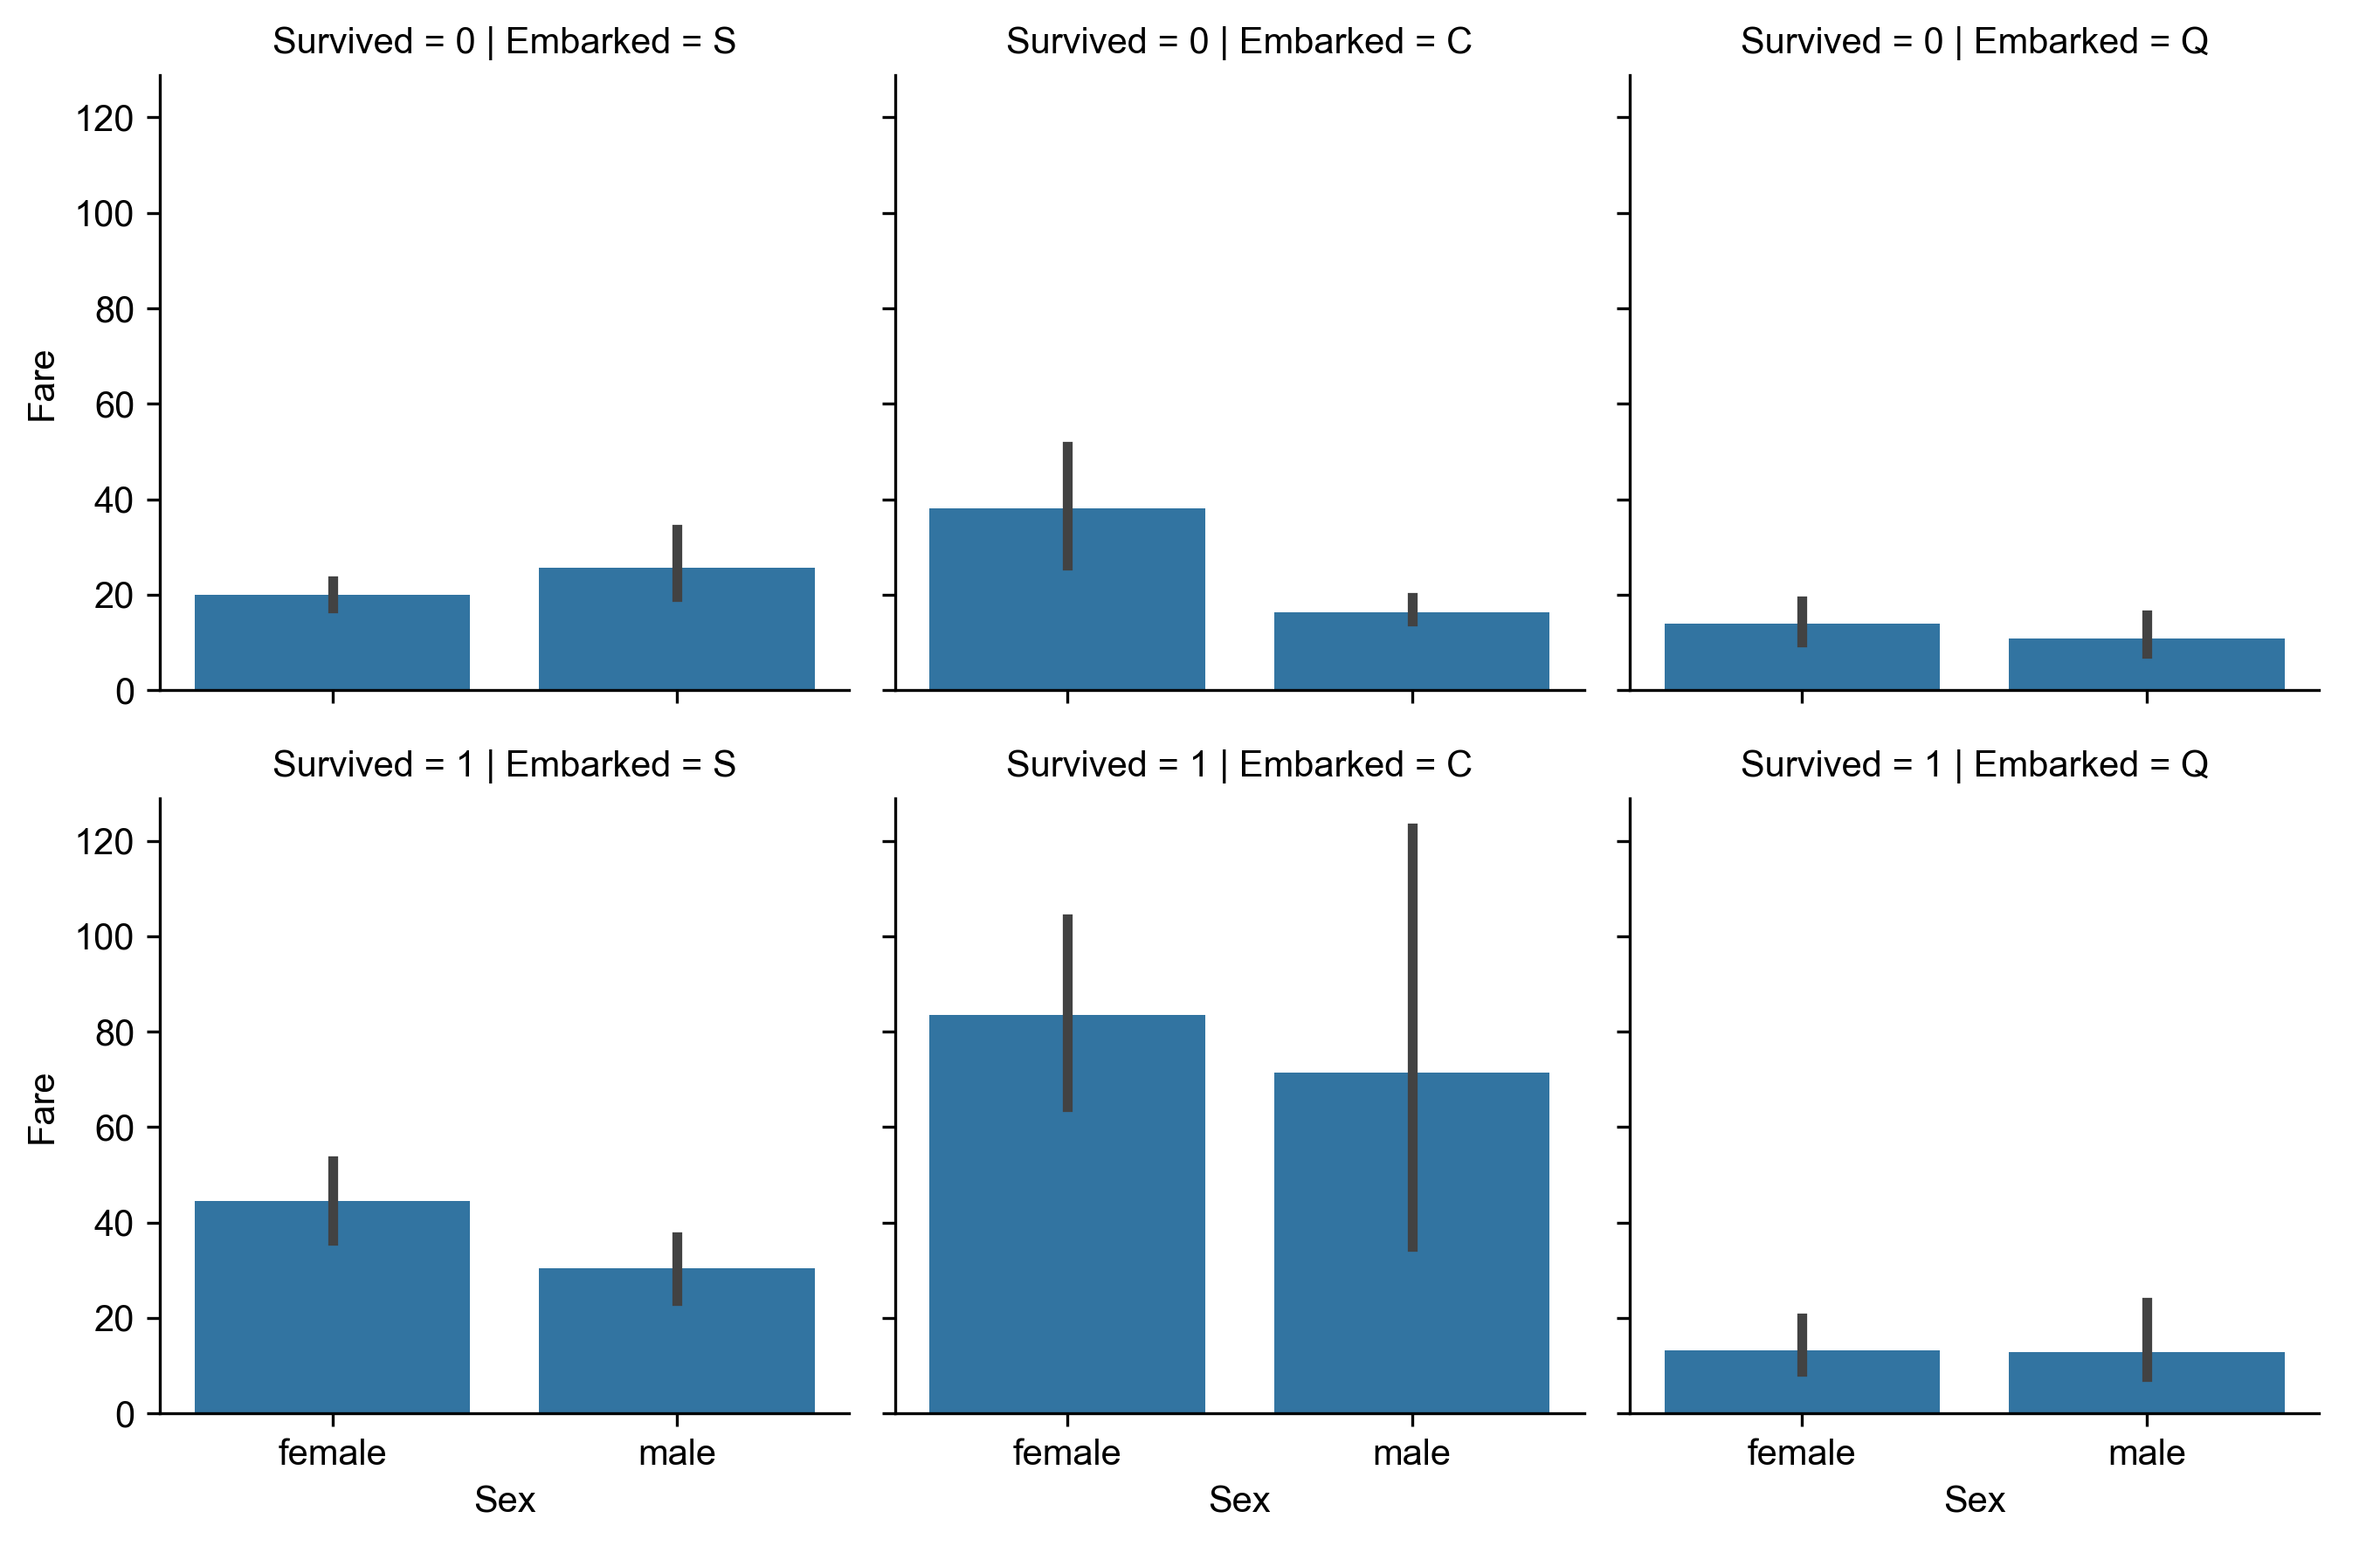

In [105]:
g = sns.FacetGrid(train, col='Embarked', row='Survived')
g.map(sns.barplot, 'Sex', 'Fare')
g.add_legend()

# Munging data

## drop features

In [153]:
train_df = train.drop(['Ticket', 'Cabin'], axis=1)
test_df = test.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]
combine[1].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


## extract title feature

In [174]:
for dataset in combine:
    dataset['Title'] = dataset.Name.apply(lambda x: ' '.join(re.findall(r'\w,\s(\w*)\..*', x)))#.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Master,0,40
Mr,0,517
,1,0
Rare,2,20
Mrs,126,0
Miss,185,0


In [160]:
for dataset in combine:
    dataset['Title'] = dataset.Title.replace('Mlle', 'Miss')
    dataset['Title'] = dataset.Title.replace('Mme', 'Mrs')
    dataset['Title'] = dataset.Title.replace('Ms', 'Miss')
    dataset['Title'] = dataset.Title.replace([
        'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir',
        'Jonkheer', 'Dona'
    ], 'Rare')
    
train_df[['Title', 'Survived']].groupby('Title', as_index=False).mean()

,Title,Survived
0,,1.000000
1,Master,0.575000
2,Miss,0.702703
3,Mr,0.156673
4,Mrs,0.793651
5,Rare,0.318182


In [147]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,male,34.5,0,0,7.8292,Q,1
1,893,3,female,47.0,1,0,7.0000,S,3
2,894,2,male,62.0,0,0,9.6875,Q,1
3,895,3,male,27.0,0,0,8.6625,S,1
4,896,3,female,22.0,1,1,12.2875,S,3


## convert categorical to numerical features

In [ ]:
'''
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Title'] = dataset['Title'].astype(int)

print(train_df.head())
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)

print(train_df.head())
'''

## completing age feature

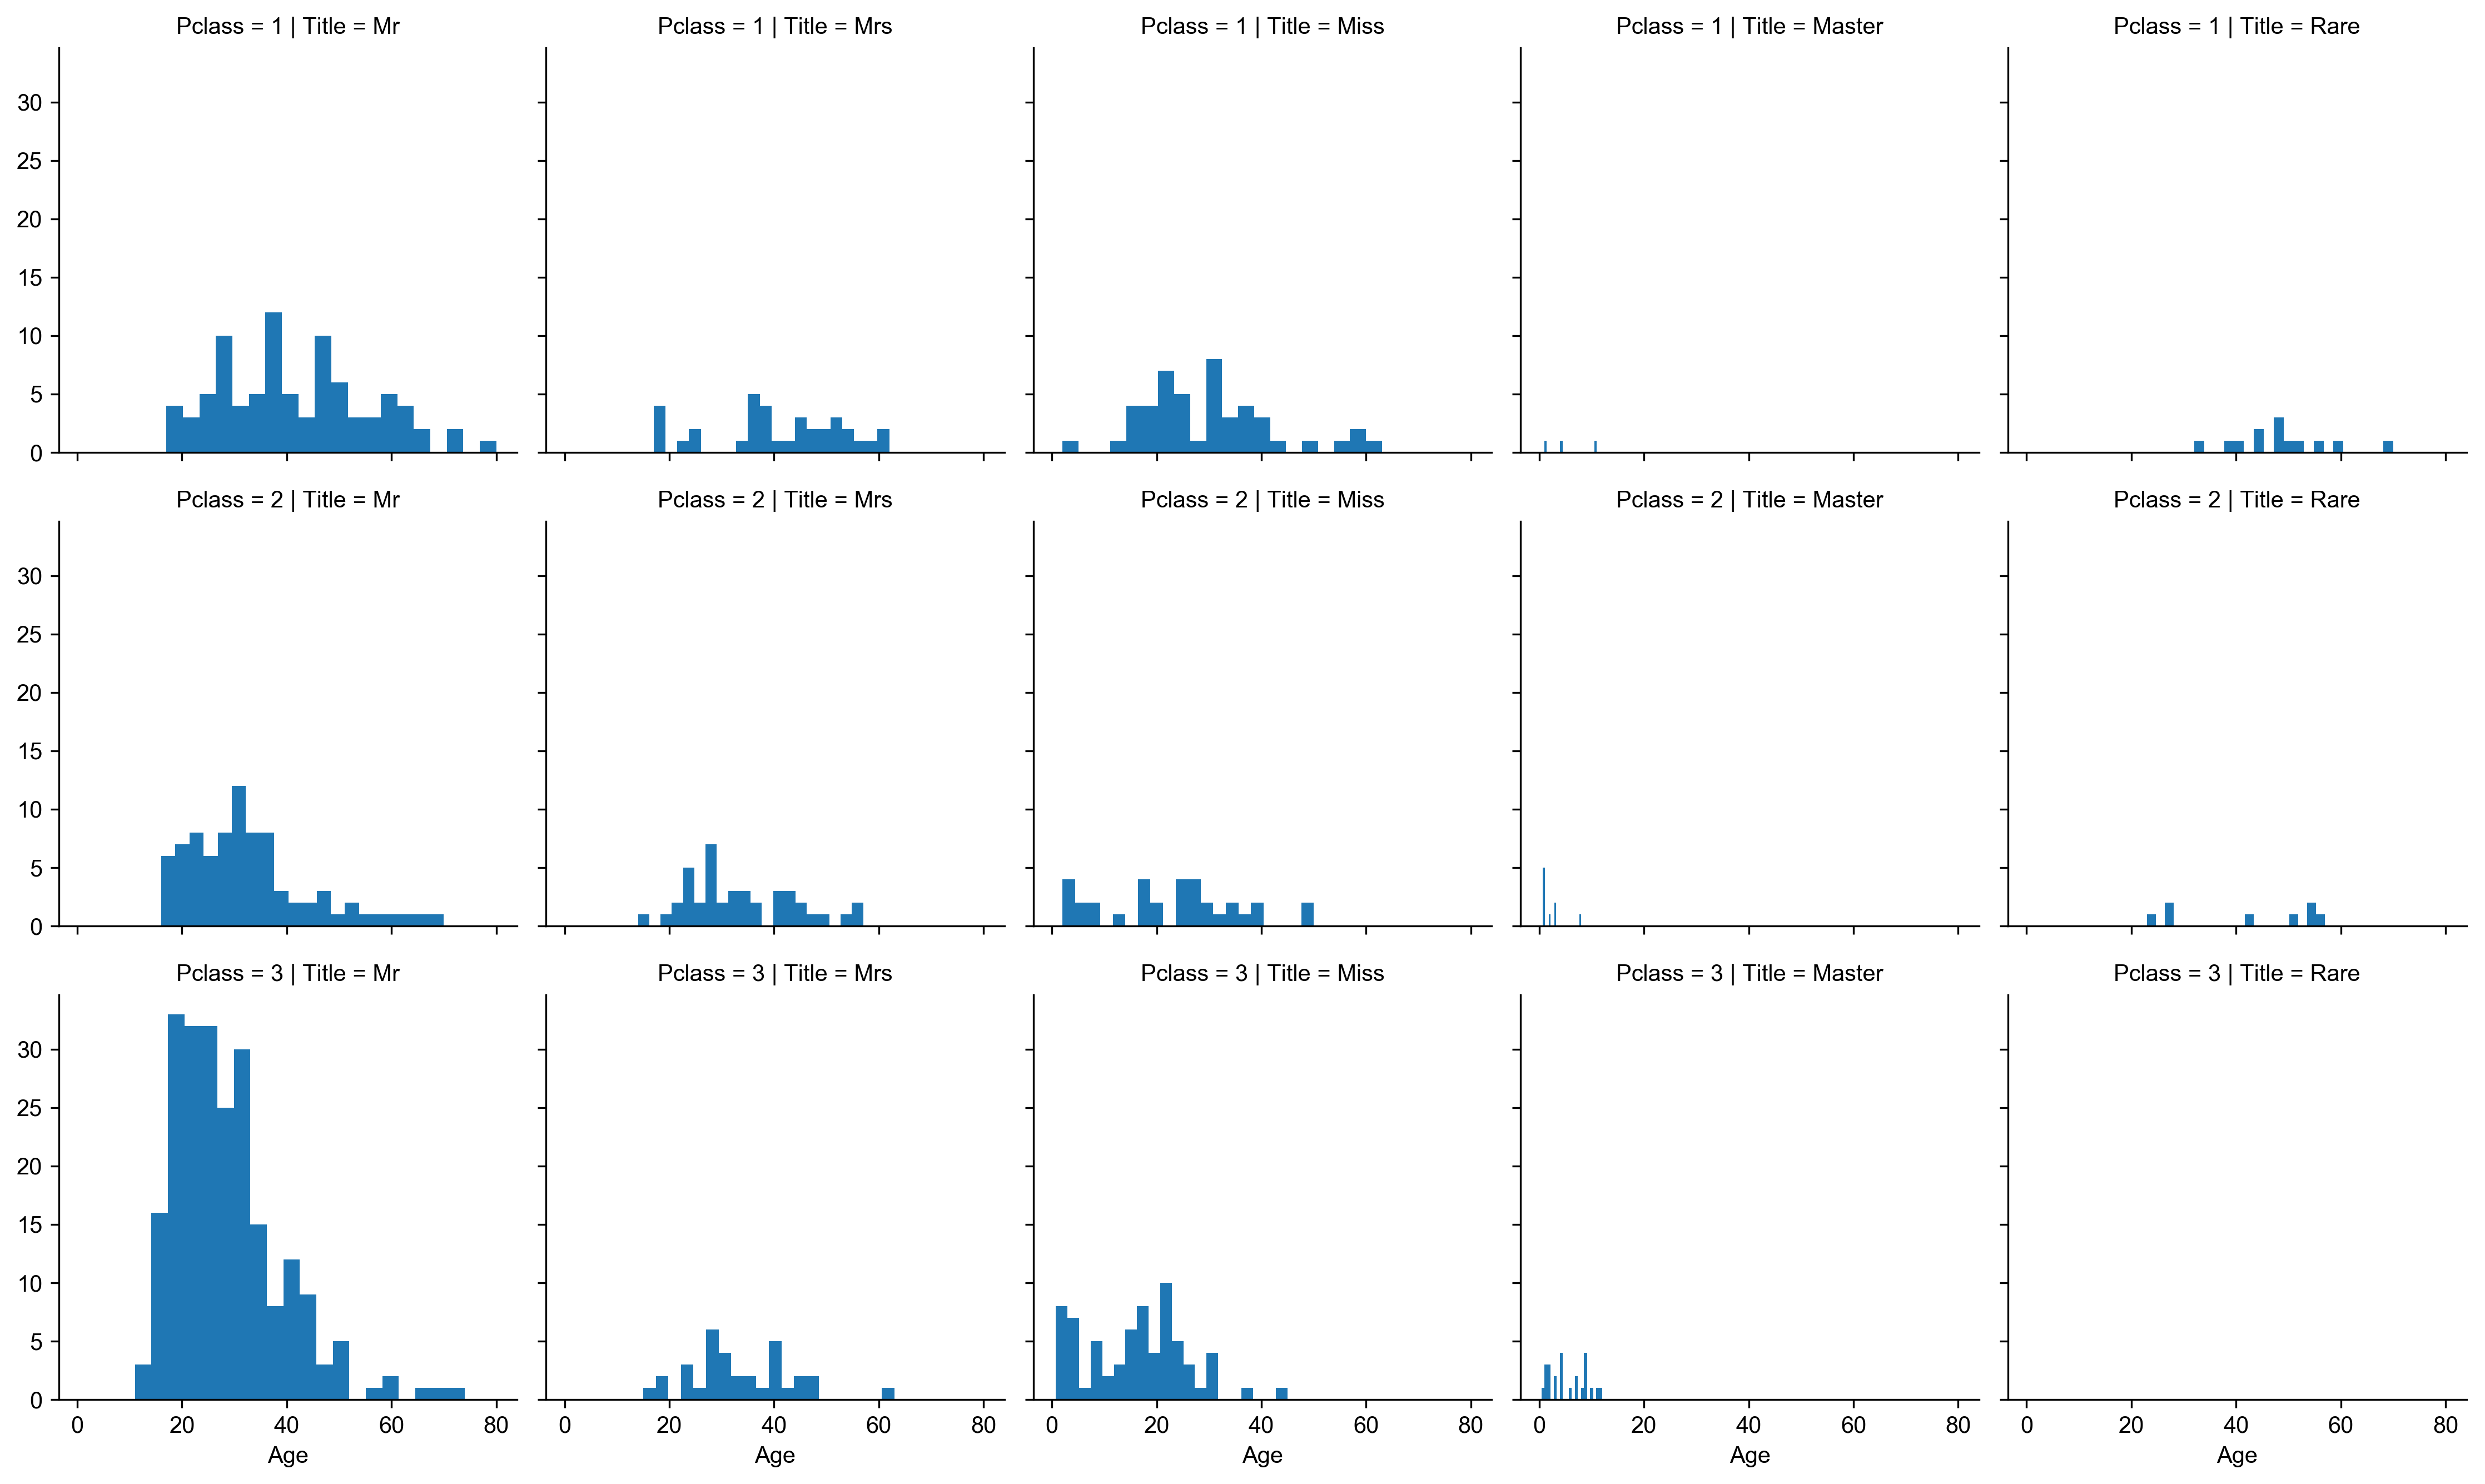

In [168]:
g = sns.FacetGrid(train_df.loc[train_df.Title.str.len() > 1], col='Title', row='Pclass')
g.map(plt.hist, 'Age', bins=20)

In [148]:
pd.get_dummies(train_df.drop(['Name', 'PassengerId'], axis=1)).columns

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,S,1
1,1,1,0,38.0,1,0,71.2833,C,3
2,1,3,0,26.0,0,0,7.9250,S,2
3,1,1,0,35.0,1,0,53.1000,S,3
4,0,3,1,35.0,0,0,8.0500,S,1
